Author: Lewis Li (lewisli@stanford.edu)

## Introduction
In this notebook, we demonstrate an implementation of Evidential Learning (Chapter 7) for predicting future production rates using historical production (Scenario 3 from Chapter 8.2). The reservoir under consideration is located in the Sirte Base in Libya. The geological setting is described in (Ahlbrandt,2005), and considers the region to have been structurally weakened due to alternating periods of uplift and subsidence originating in the Late Precambrian period, commencing with the Pan-African orogeny that consolidated several proto-continental fragments into an early Gondwanaland. Rifting is considered to have commenced in the Early Cretaceous period, peaked in the Late Cretaceous period, and ended in the early Cenozoic. The Late Cretaceous rifting event is characterized by formation of a sequence of northwest-trending horsts (raised fault blocks bounded by normal faults) and grabens (depressed fault blocks bounded by normal faults) that step progressively downward to the east. These horsts and grabens extend from onshore areas northward into a complex offshore terrene that includes the Ionian Sea abyssal plain to the northeast (Fiduk,2009).  We consider the situation where 5 producers and 3 injectors have already been drilled at the locations shown below:

<img src="../figures/EvidentialLearning/FieldOverview.png",width="400",style="float: center">

The field has been in production for 4000 days, and production data is available for all 5 wells. A decision needs to be made regarding the economic feasibility of the field in the future. The decision of when to abandon the field is contingent on the field production from day 4000 to 9000 assuming current operating conditions. 

## Prior Model Construction
As discussed in Chapter 7, the first step of Evidential Learning is obtaining the training set using prior information. In this instance, we have prior information regarding both the gridded (spatial) and non-gridded components of the reservoir model. Seismic data suggested the presence of 4 faults and 2 deformable horizons. In this case, a brittle deformation is modeled with no smearing. The constructed structural and  stratigraphic models are shown below. In this case study, fault locations and displacements are assumed to be known. 
<img src="../figures/EvidentialLearning/LibyanStructural.png",width="700",style="float: center">'
The prior lithology information comes from existing wells. In the Libyan reservoir, there are five existing producers from which the prior information is extracted. Analysis indicates the presence of three distinct facies: low-quality sand, high quality sand and dolomite.  

Furthermore, studies on the cores along with field studies provide the prior ranges and distributions for permeability and porosity for each of the facies as shown in the table below. Any sampled prior models should have petrophysical parameters that follow these distributions. 

Facies  |  Porosity (%) |  Permeability (mD)  
-----------------------|-------------|------------------
Low quality sand | $\mathcal{U}(8,15)$ |  $\ln \mathcal{N}(110,400)$ 
High quality sand | $\mathcal{U}(20,30)$ | $\ln \mathcal{N}(1000,5000)$ 
Dolomite | $\mathcal{U}(10,20)$ | $\ln \mathcal{N}(10,15)$ 

The non-gridded parameters pertain to the reservoir fluid characteristics (relative permeability, oil viscosity, etc), as well as the transmissibility of the four faults in the reservoir. The prior on these parameters is shown below:

Name  |  Symbol |  Prior $f(m_i)$ 
-----------------------|--------------------|--------------------
Oil Water Contact | $OWC$ |  $\mathcal{U}[1061,1076]$ 
Fault 1 Transmissibility Multiplier | $F_1$ | $\mathcal{U}[0,1]$
Fault 2 Transmissibility Multiplier | $F_2$ | $\mathcal{U}[0,1]$
Fault 3 Transmissibility Multiplier | $F_3$ | $\mathcal{U}[0,1]$
Fault 4 Transmissibility Multiplier | $F_4$ | $\mathcal{U}[0,1]$
Oil Viscosity | $\mu$ | $\mathcal{N}(4,0.5)$ 
Irreducible Oil Saturation | $S_{or}$ | $\mathcal{N}(0.2,0.05)$ 
Irreducible Water Saturation | $S_{wc}$ | $\mathcal{N}(0.2,0.05)$ 
Oil End Point Relative Perm K | $k_{ro}$ | $\mathcal{U}[0.1,0.4]$ 
Water End Point Relative Perm K | $k_{rw}$ | $\mathcal{U}[0.1,0.4]$ 
Corey Coefficient Oil | $n_{o}$ | $\mathcal{U}[2,3]$ 
Corey Coefficient Water | $n_{w}$ | $\mathcal{U}[4,6]$ 

### Geostatistical Simulation
To generate the prior reservoir models, we need to use the prior information described above and simulate plausible reservoir model realizations. The non-gridded model variables are straightforward to simulate as a Monte Carlo study can be readily performed. To generate realizations of the gridded model parameters, we need to apply geostatistical simulation. The structural and stratigraphic parameters are considered to be known in this case, so we will use the grid from  for each prior model realization. The next task is the generation of the spatially varying petrophysical parameters. As discussed in the previous section, the petrophysical parameters are heavily dependent on the lithology, so we need to first simulate the lithology realizations before generating the corresponding porosity and permeability realizations. The overall workflow is shown below:

<img src="../figures/EvidentialLearning/GeostatModeling.png",width="700",style="float: center">'

The modeling workflow was accomplished using SGEMS (Remy, Boucher, & Wu, 2011).

### Forward Simulation
A total of 500 prior models were generated using the modeling workflow described in the previous section. The next step is to forward simulate these prior models using a streamline simulator (3DSL) over all 9000 days. This encompasses both the 4000 days of production data denoted by $\mathbf{d}$, as well as the 5000 days of prediction $\mathbf{h}$ required to make the decision regarding abandonment. These simulations can be performed in parallel. Any simulator can be used as the only requirement is the ability to export the simulation results into some format that can be processed by MATLAB, R, Python, etc. See _Process3DSLResults.m_ for an example of how we processed 3DSL results into a MATLAB struct.




## Uncertainty Quantification with Evidential Learning
Once we have the prior data and prediction variables, we can move onto the uncertainty quantification component of the analysis. We begin by adding the required libraries for Evidential Learning.

In [1]:
addpath('../src/evidential/');
addpath('../src/thirdparty/fda_matlab/');

### Loading Prior Data and Prediction Variables
We use a struct for storing both the prior and data and prediction variables. The struct has the following fields:

Name  |  Data Type  |  Dimensions                  |  Description     
------------|-------------|--------------------------|------------------------------
time       |  double     |  $1 \times N_{t}$  |  A vector containing the time (days, years) at each time step
data    |  double     |  $N_{real}\times N_{t}\times N_{responses}$          | Data array that contains responses. Each row is one realization, each y is a time step, and each z is a different well
name     |  string  |  1            |  The name of the response, ex: 'Oil Rate'
spline      |  double  | $2$     |  First element specifies order of spline, second the number of knots that will be used for FDA
ObjNames      |  CellArray  |   $N_{responses} \times 1$    |  Contains the name of each well ex: {'P1','P2'}
types      |  string  |  1     |  'Data' or 'Prediction'

The main pitfall that can occur here is that depending on the realization and simulator, the data and prediction rates may be on different time steps. It is recommended to remap all the prior realizations onto a single set of time steps using some form of interpolation.  See _GenerateDataStructsWithInterpolation.m_ for an example of how we did using linear interpolation. For sake of illustration, we saved these post-processed prior variables as _Prior.mat_. This should be replaced with your dataset!

In [2]:
prior_path = '../data/evidential/Prior.mat';
load(prior_path);

For benchmarking, we will set one realization aside and use that as the truth. In this particular case, realization 464 was chosen as the reference. The production data from each of the 5 producers is shown below. The reference is shown in red ($\mathbf{d}_{obs}$), while the historical responses from the prior model are shown in gray ($\mathbf{d}$).

In [3]:
% Set aside a realization to use as the "truth"
TruthRealization = 464;
NumPriorRealizations=length(PriorData.data);
AvailableRealizations = setdiff(1:NumPriorRealizations,TruthRealization);


To verify that our prior variables loaded correctly, we first plot them. The function _PlotPriorResponses_ is used for this purpose. Our data variable consists of 5 production rates over 4000 days.

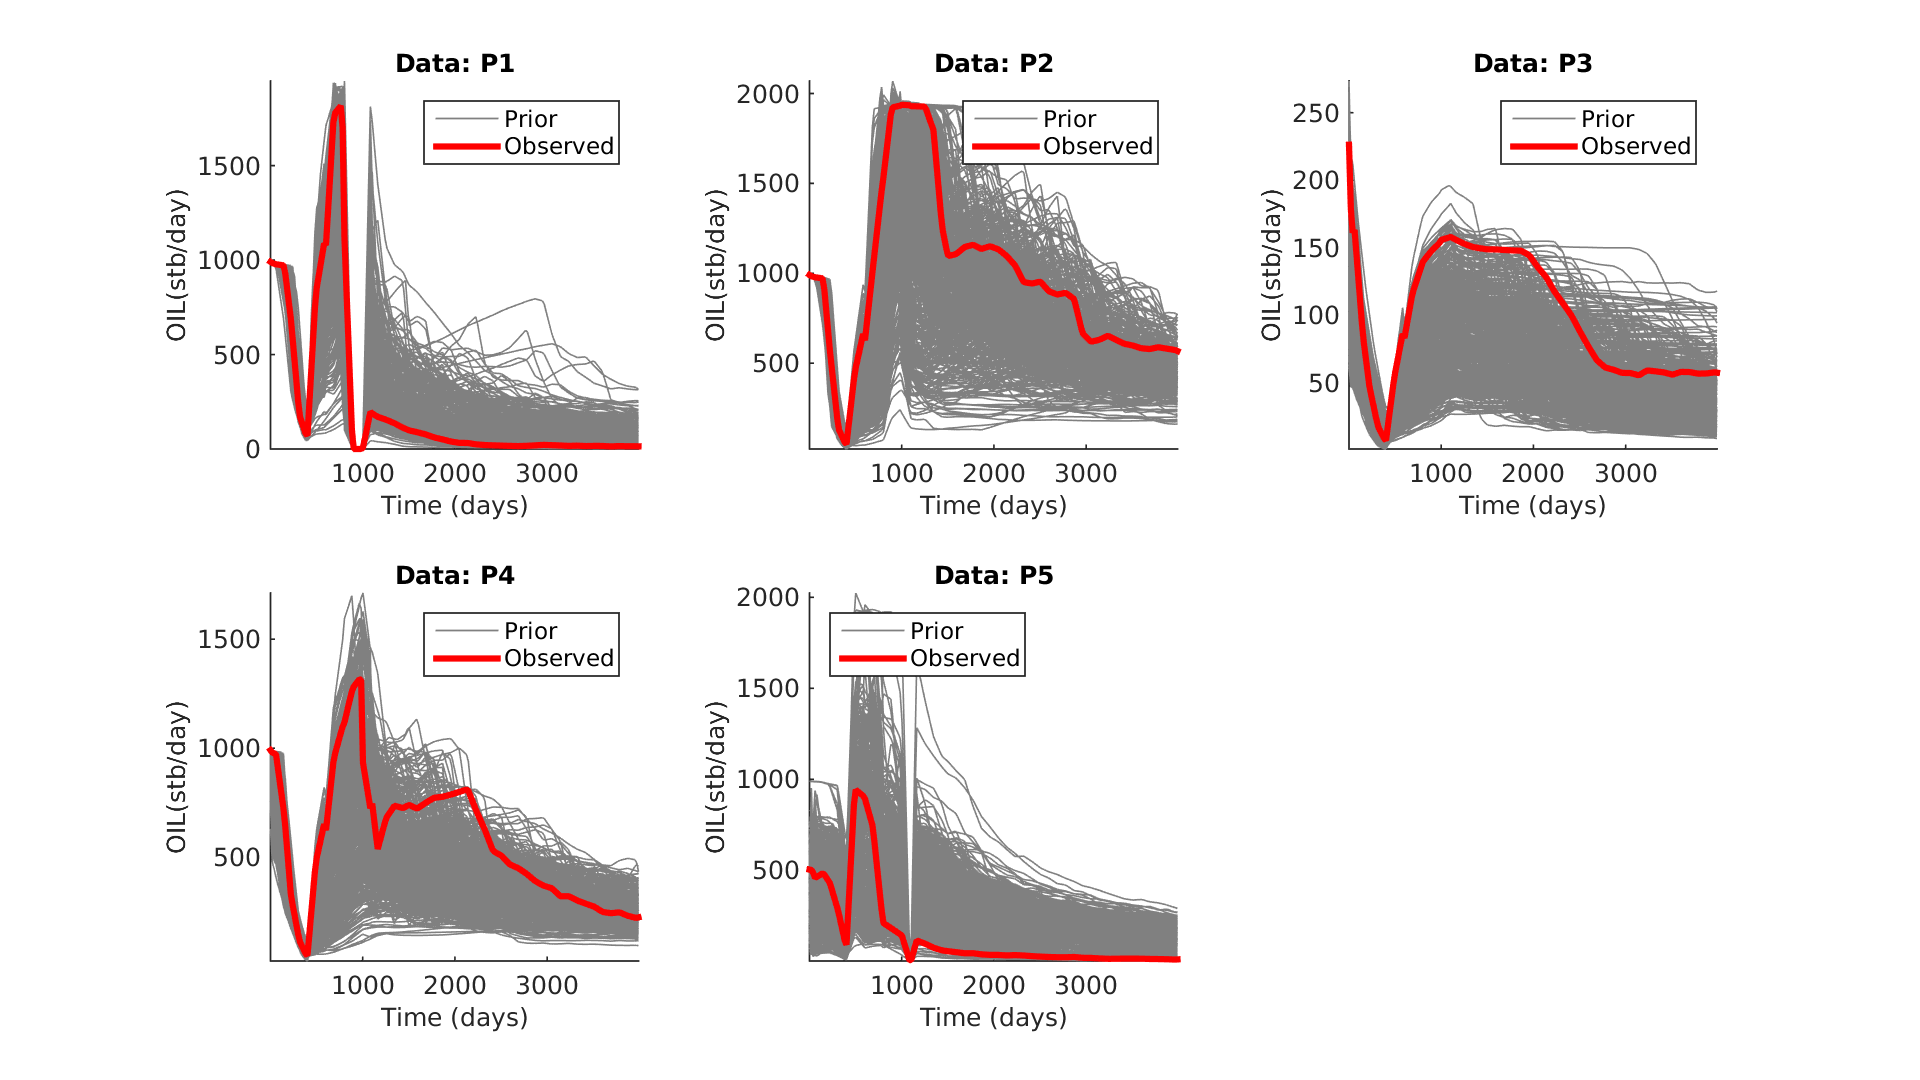

In [4]:
%plot inline -s 1920,1080
FontSize=12;
PlotPriorResponses(PriorData,TruthRealization,FontSize);

Likewise, we can plot the prediction variable $\mathbf{h}$ which is the field production rate from day 5000 to 9000.

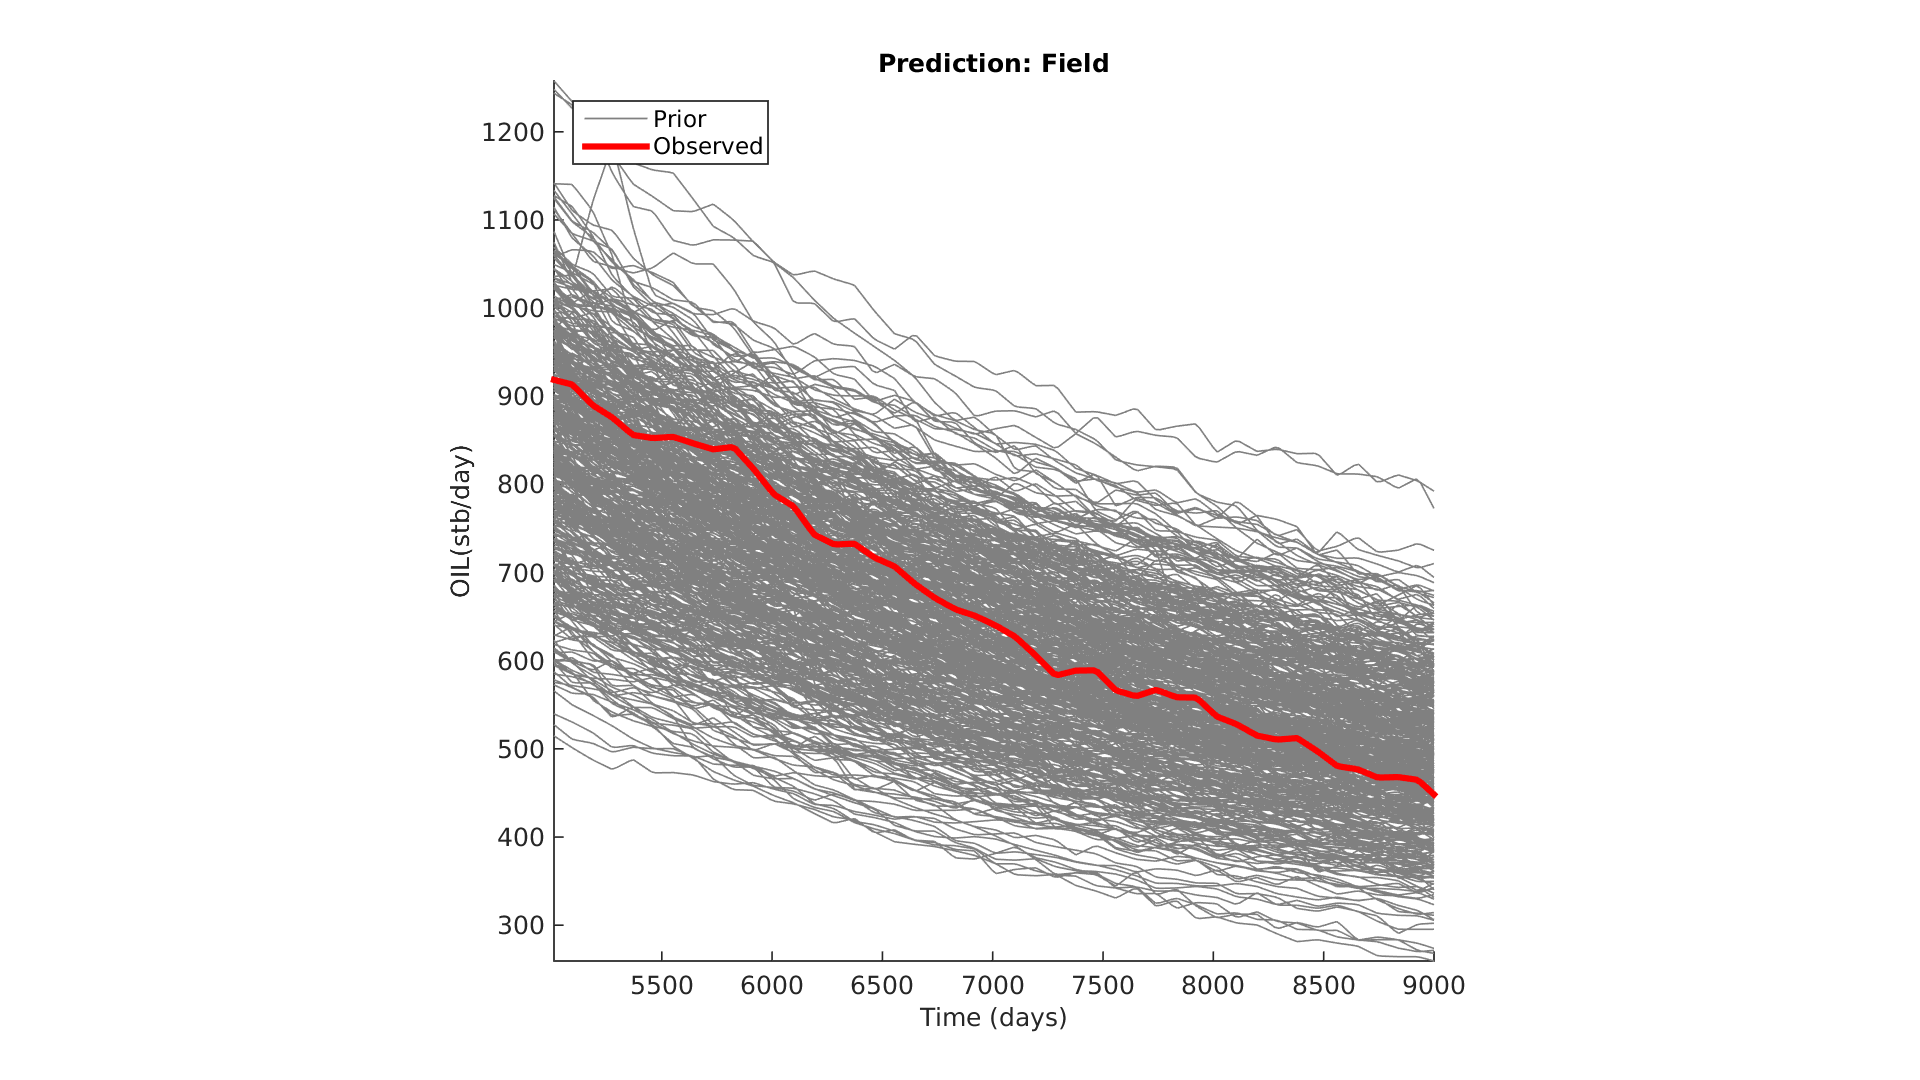

In [5]:
%plot inline -s 1920,1080
PlotPriorResponses(PriorPrediction,TruthRealization,FontSize);

### Dimension Reduction
Each of the response time series are technically infinite dimension, but have been discretized to 80 time steps for purposes of flow simulation. We require a dimension reduction before we can build a statistical relationship between data and prediction. 

#### Functional Data Analysis
We start by performing Functional Data Analysis on each of the five historical rates that comprise the data variable (Chapter 2.6). We can achieve further compression by applying Functional Princpal Component Analysis (FPCA) (Ramsay, 2006). The effectiveness of the compression can be verified by inspecting the scree plot. In this case, we will look at the decomposition of Producer #1's historic oil production rate.


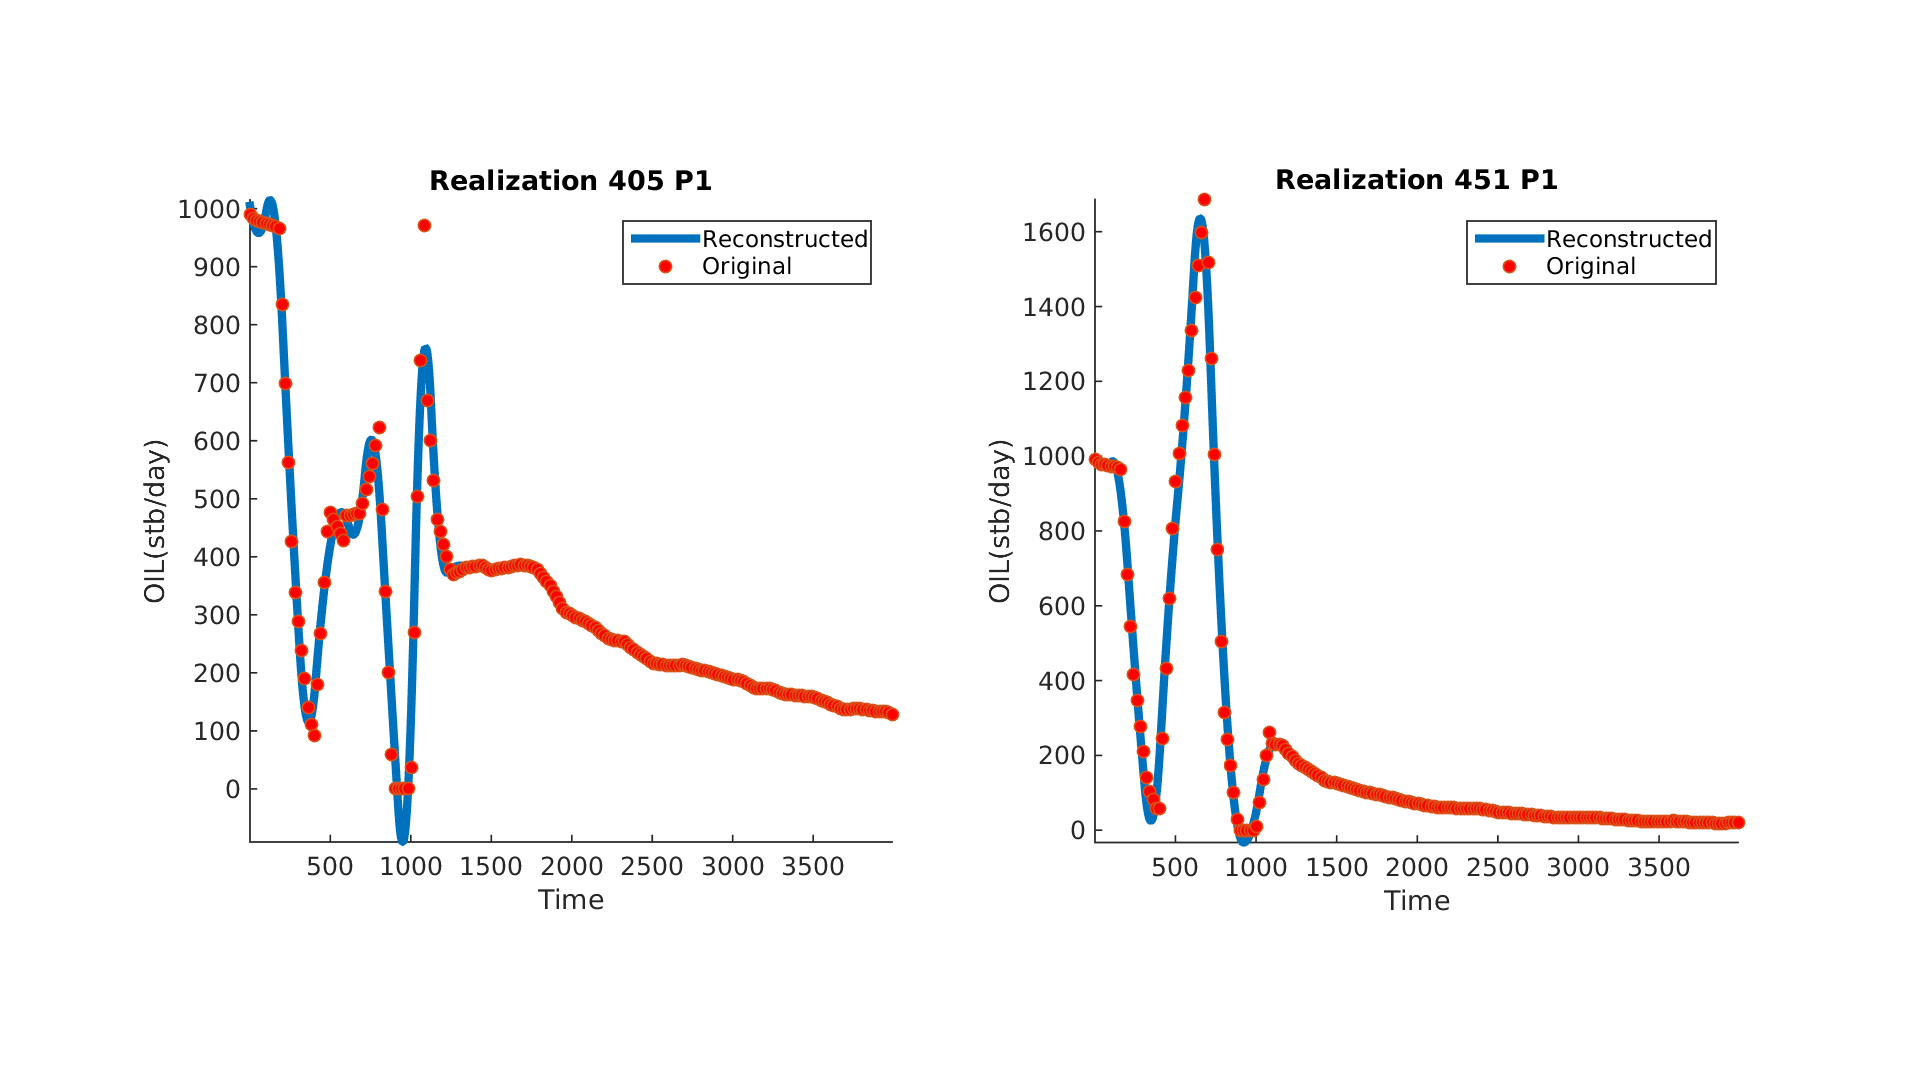

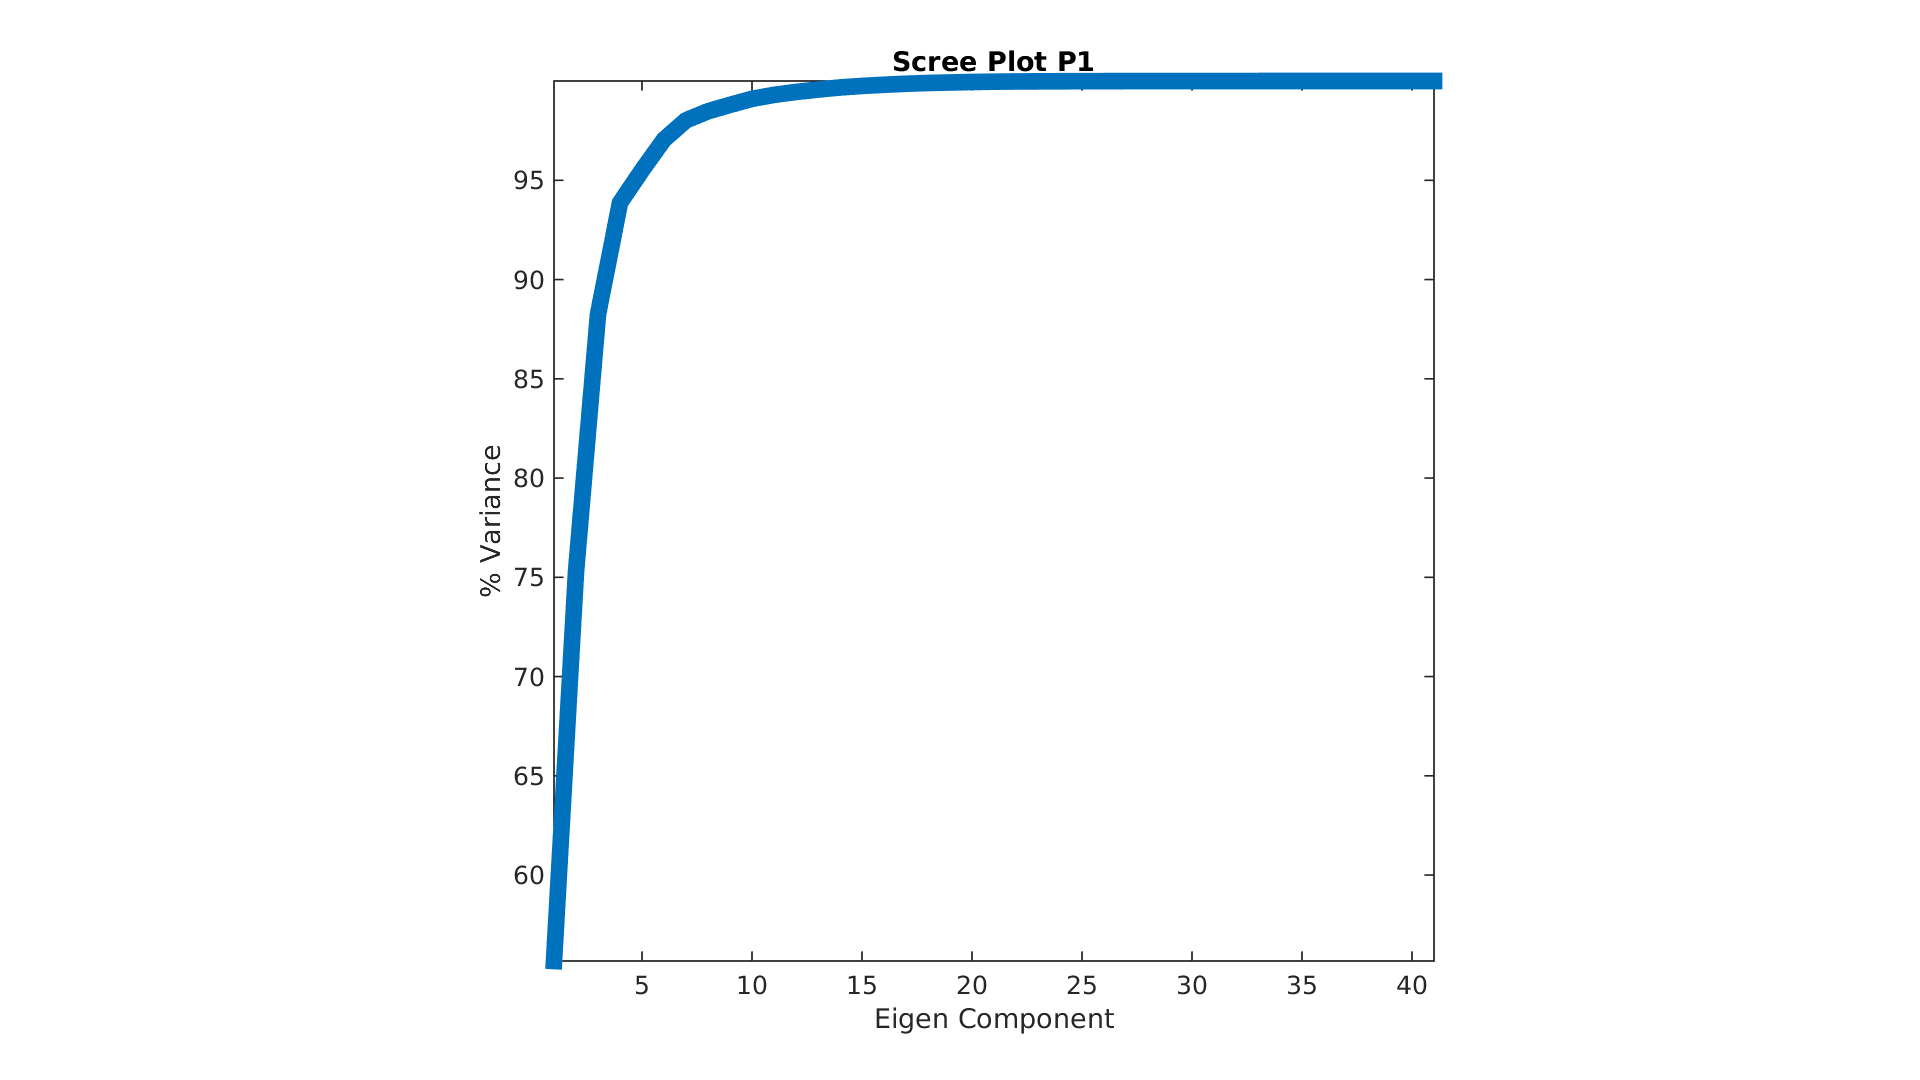

In [6]:
%plot inline -s 1920,1080
MinEigenValues = 3; EigenTolerance = 0.95;

% We first perform FPCA on both d and h
PriorData.spline=[3 40]; % 3rd order spline with 40 knots
PriorDataFPCA = ComputeHarmonicScores(PriorData,4);

The choice of basis spline is motivated by the ability to reconstruct the original time series after FPCA. This is generally selected as an iterative process. To decide the number of eigenbasis to retain, we will need to examine the scree plot. In our case, the scree plot shows that only the first 5 eigencomponents are required to capture over 95% of the variation in the response of all the prior models for Producer 1. The choice of spline is then iteratively adjusted to minimize the average RMS between the original. It is also important to ensure that oscillations caused by Runge’s phenomena do not occur over any of the models, when high order splines are used. We verify the effectiveness of the compression by reconstructing the original curves from the basis functions and coefficients. The same procedure is applied to $\mathbf{h}$ resulting in 4 eigencomponents.

In [7]:
PriorPrediction.spline=[3 20]; % 3rd order spline with 20 knots
PriorPredictionFPCA = ComputeHarmonicScores(PriorPrediction,0);

### Mixed PCA
We next apply Mixed PCA (Abdi et al, 2013) to remove any multicollinearity between the historical rates of the five producer wells as well as reducing the dimension of $\mathbf{d}$ further: 

In [8]:
rmpath('../src/thirdparty/fda_matlab/');
[d_f, dobs_fpca] = MixedPCA(PriorDataFPCA,TruthRealization,EigenTolerance);
addpath('../src/thirdparty/fda_matlab/');

% Get number of FPCA components to keep for h
nHarmPred = GetNumHarmonics(PriorPredictionFPCA{1}, MinEigenValues, ...
    EigenTolerance);
h_f = PriorPredictionFPCA{1}.harmscr(AvailableRealizations,1:nHarmPred);


### Transformations
So we have now effectively reduced our dimension from 5 producers and 80 element time series into 11 dimensions (7 from the producers $\mathbf{d}^{fpca}$ and 4 from the prediction $\mathbf{h}^{f}$. This enables the possibility of performing regression between data and prediction. However, this is contingent on a sufficiently strong linear correlation between the variables, or else the resulting estimates from regression will be inconsistent. We verify this by examining the correlation between the functional components of the prior data and prediction variables.

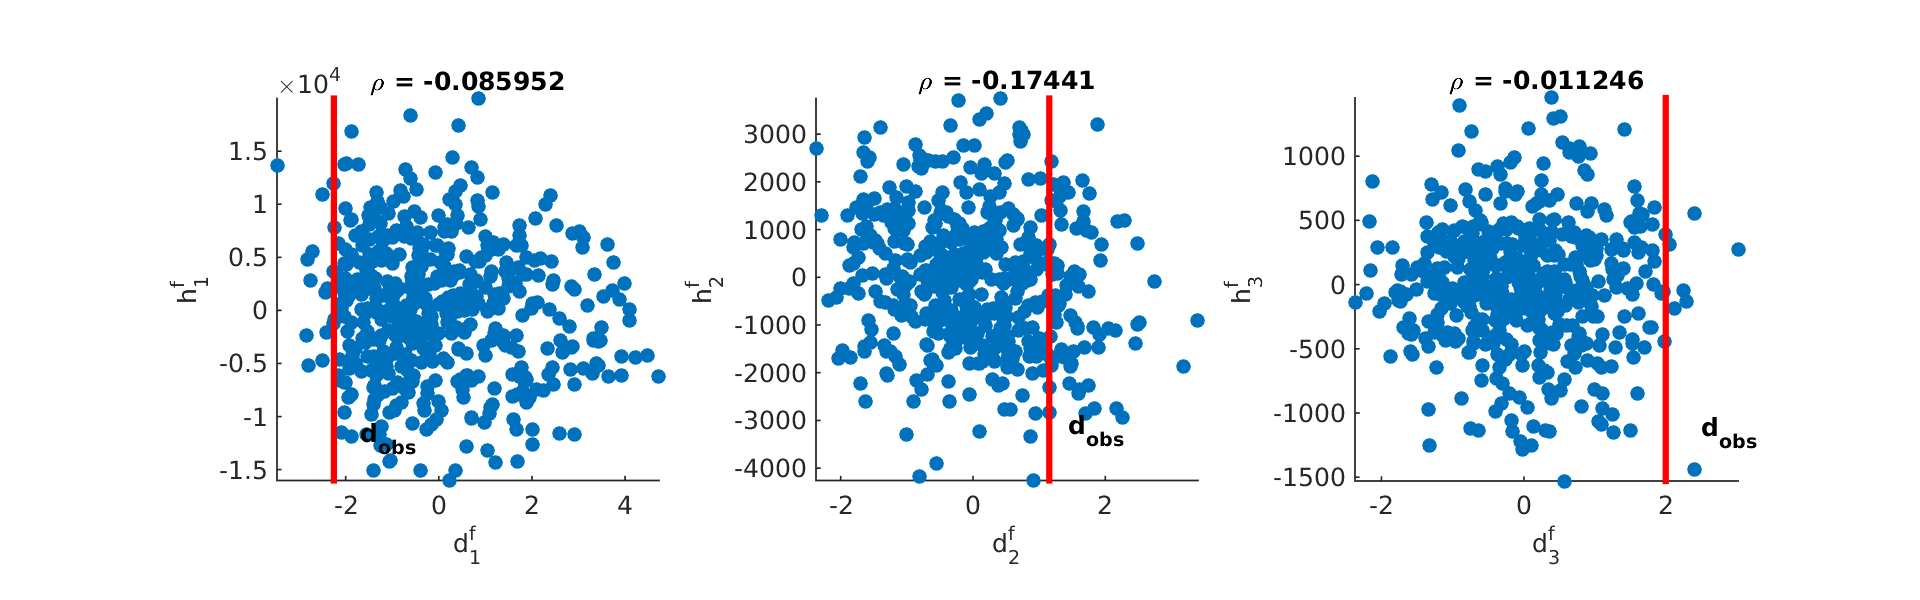

In [9]:
%plot inline -s 1920,600
% Plot prior models in functional space
PlotLowDimModels(d_f,h_f,dobs_fpca,'f',FontSize);


#### Canonical Correlation Analysis
In this example, the correlation between first functional components of data and forecast is rather poor. This is usually attributed to the presence of cross-correlations among the functional data variables. To fully capitalize on the full multi-variate correlation between all component of h and all components of d a Canonical Correlation Analysis (Chapter 2.5) (Thompson, 2005) is performed to transform the models into a canonical space. 

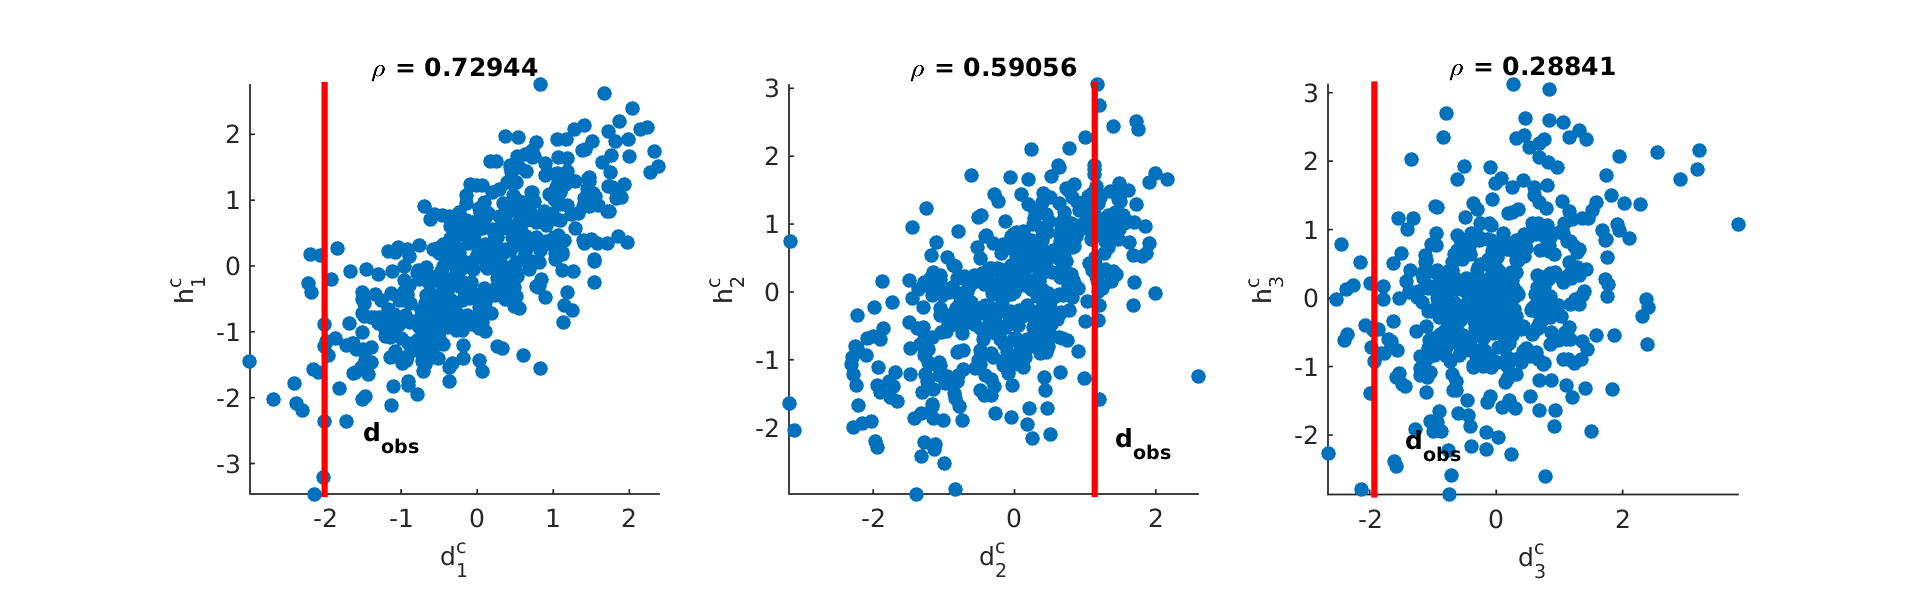

In [10]:
%plot inline -s 1920,600
% Compute canonical transformation on the functional components
[A, B, ~, d_c,h_c] = canoncorr(d_f,h_f);
dobs_c=(dobs_fpca-mean(d_f))*A;

% Plot prior models in canonical space
PlotLowDimModels(d_c,h_c,dobs_c,'c',FontSize);

We see that the correlation between the primary canonical components of the data and prediction variables is much higher than in the functional space. 

#### Normal Score Transform
The dimension of this problem is large enough that non-parametric regression such as KDE would be challenging. For parametric regressions such as Linear Gaussian Regression, a Gaussian assumption is neccessary. To ensure that this is valid, we apply a Normal Score Transform to $h_c$.

In [11]:
% Apply a normal score transform to the h_c
h_c_gauss = NormalScoreTransform(h_c,0);

### Regression
When the prior and likelihood distributions come from certain probability distribution families, an analytical expression can be derived for the posterior distribution $f(\mathbf{h}^*|\mathbf{d}^*_{obs})$. This is advantageous as it avoids potentially computationally expensive numerical integrations to obtain the posterior. One such family of probability distributions is the Gaussian distribution. That is if the likelihood function and prior are Gaussian, the posterior will also be Gaussian. Under such an assumption, Gaussian Process Regression can be applied.

The linear relationship between data and forecast implies we can express:
$$\mathbf{d}^c =\mathsf{G}_{dh}\mathbf{h}^c$$
Likewise, a Gaussian likelihood model formulated as follows:
$$L(\mathbf{h}^c) = exp(\frac{1}{2}(\mathsf{G}_{dh}\mathbf{h}^c-\mathbf{d}^c_{obs})^TC^{-1}_{\mathbf{d}^c} (\mathsf{G}_{dh}\mathbf{h}^c-\mathbf{d}^c_{obs})$$
where $C^{-1}_{\mathbf{d}^c}$ is the data covariance matrix of the canonical components. Since prior and likelihood are multi-variate Gaussian, the posterior is also Gaussian and the posterior mean and covariance can be readily estimated using classical methods. 

In [12]:
% Find best linear fit between Dc and h_c_gauss
G = d_c'/h_c_gauss';

% Compute misfit covariance
DDiff= d_c'-G*h_c_gauss';
C_T = DDiff*DDiff'/length(d_c);

With likelihood and prior multi-variate Gaussian and a linear model, the posterior distribution $f(h^c|d_{obs})$ is also multivariate Gaussian with mean $\tilde{h^c}$ and covariance model  $\tilde{C_{h^ch^c}}$ (Tarantola, 2005). Using the empirically estimated $\hat{\mathsf{G}}_{dh}$ and $\mathsf{C}_{d^*d^*}$, the posterior mean and covariance can be found using:

$$\mathbf{\hat{h}}^*  =  (\hat{\mathsf{G}}_{dh}^T\mathsf{C}_{d^*d^*}^{-1}+\mathsf{C}_{h^*h^*}^{-1})^{-1}(\hat{\mathsf{G}}_{dh}^T \mathsf{C}_{d^*d^*}^{-1} \mathbf{d}^*_{obs} + \mathsf{C}_{h^*h^*}^{-1}\mathbf{\bar{h}^*})$$

$$\mathsf{\hat{C}}^*_{h^*h^*}  =  (\hat{\mathsf{G}}_{dh}^T\mathsf{C}_{d^*d^*}^{-1}\hat{\mathsf{G}}_{dh}+\mathsf{C}_{h^*h^*}^{-1})^{-1}$$

In [13]:
% Compute posterior using Linear Gaussian Regression Equations
C_H = cov(h_c_gauss);
mu_prior = mean(h_c_gauss)';
mu_posterior = mu_prior + C_H*G'*pinv(G*C_H*G' + C_T)*(dobs_c'-G*mu_prior);
C_posterior = inv(G'*pinv(C_T)*G + inv(C_H));

### Sampling The Posterior
Gaussian regression thus produces a multi-variate normal posterior $f(\mathbf{h}^c|\mathbf{d}^c_{obs})$, that is easily sampled from to produce forecast components conditioned to $\mathbf{d}^c_{obs}$. We can thus generate posterior by simply sampling from this multivariate Gaussian. Sampling from a multi-variate Gaussian is a simple procedure (refer to _SampleCanonicalPosterior.m_).

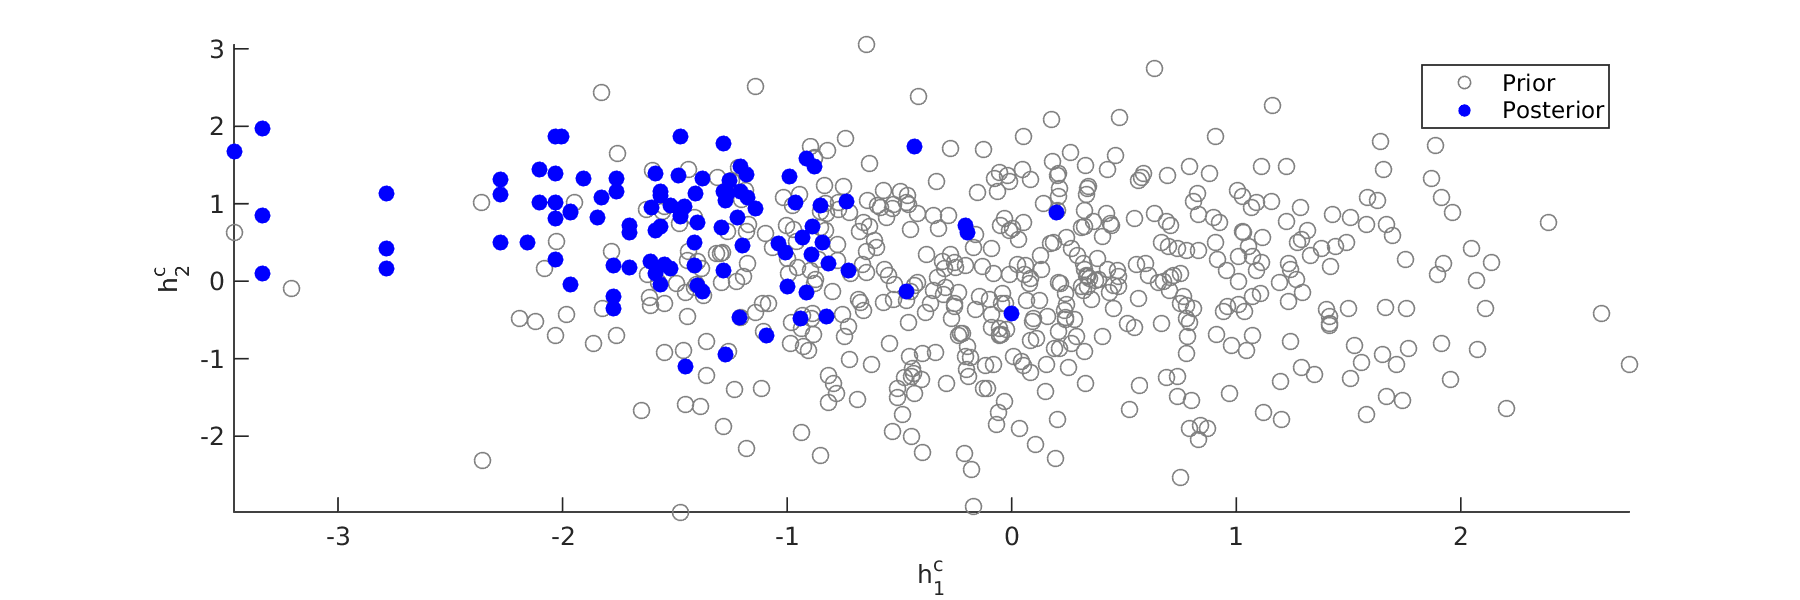

In [17]:
%plot inline -s 1800,600
warning('off','all');
addpath('../src/thirdparty/fda_matlab/');
NumPosteriorSamples = 100;
h_c_post = SampleCanonicalPosterior(mu_posterior,C_posterior,...
    NumPosteriorSamples,h_c);


We are not however, interested in posterior predictions in the canonical space; rather we need to transform them back into the time-domain. We thus need to undo each of the transformations. We start by undoing the normal score transform. We can then observe the reduction in variance in the posterior models (blue) versus prior (gray). This represents that a reduction in prediction uncertainty should be achieved. We need to undo the canonical transform, followed by the FPCA and FDA (refer to _UndoCanonicalFunctional.m_) for this implementation.

In [15]:
% Undo the CCA and FPCA transformations
h_reconstructed = UndoCanonicalFunctional(h_c_post, B, h_f,...
    PriorPrediction.time, PriorPredictionFPCA);

We can then plot the posterior predictions in the time domain, as well as compute the updated P10,P50,P90. The posterior quantiles exhibit a significant reduction in uncertainty in comparison to the prior. 

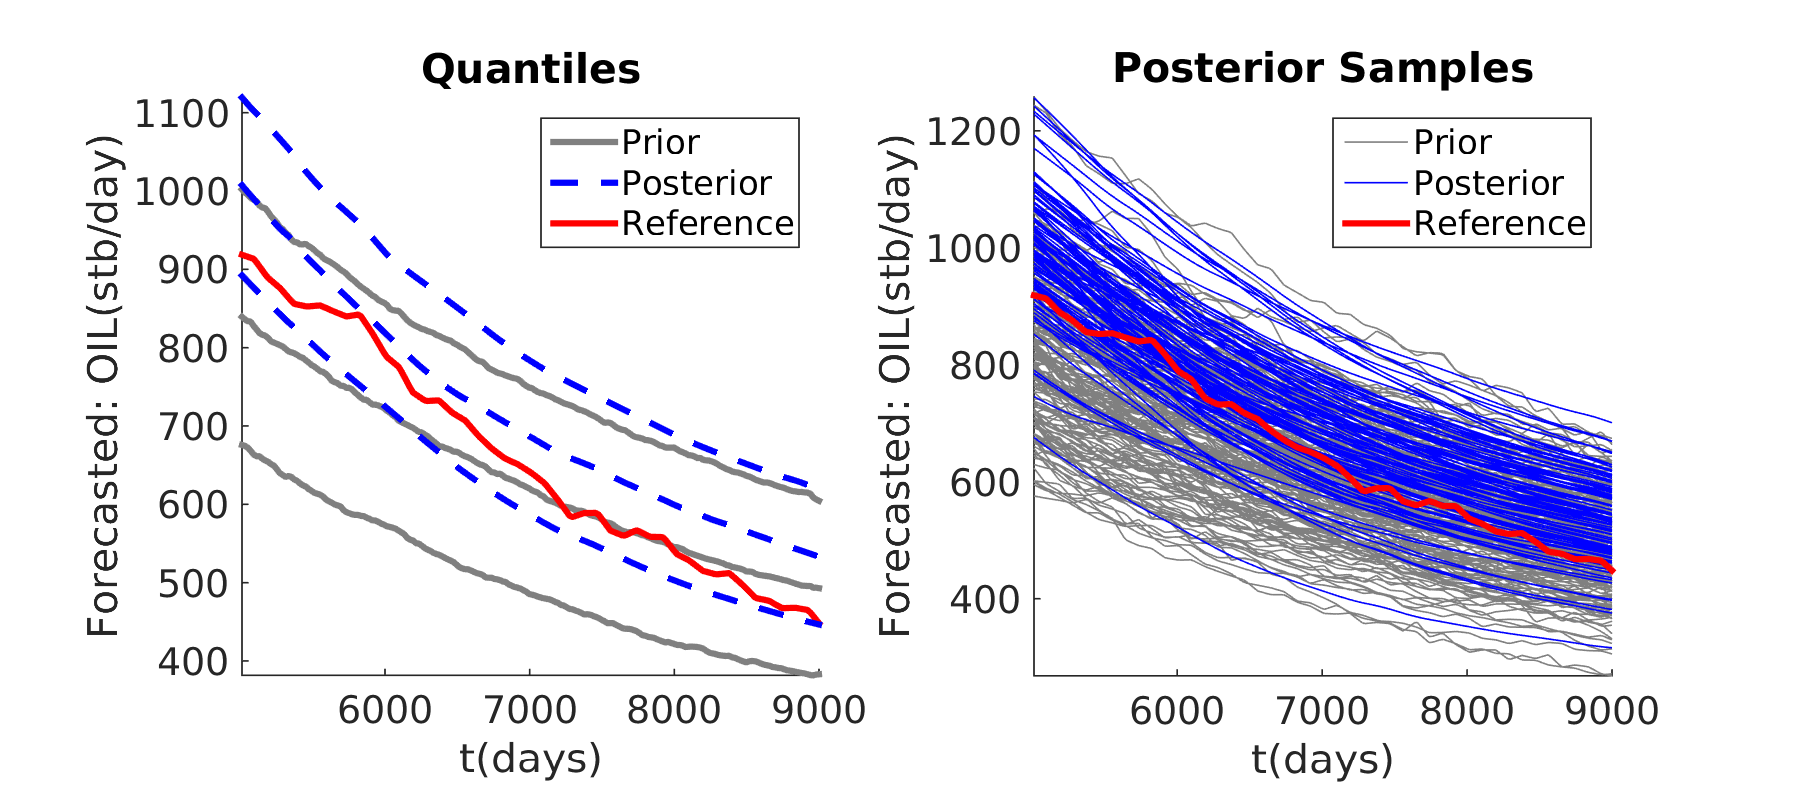

In [16]:
%plot inline -s 1800,800
[PriorQuantiles, PosteriorQuantiles] = ComputeQuantiles(...
    PriorPrediction.data, h_reconstructed');
PlotPosteriorSamplesAndQuantiles(PriorPrediction,TruthRealization, ...
    h_reconstructed',PriorQuantiles,PosteriorQuantiles);

## References

Abdi, Herve, Lynne J. Williams, and Domininique Valentin. "Multiple factor analysis: principal component analysis for multitable and multiblock data sets." Wiley Interdisciplinary Reviews: Computational Statistics 5.2 (2013): 149-179.

Ahlbrandt, Thomas S. The Sirte Basin Province of Libya: Sirte-Zelten Total Petroleum System. US Department of the Interior, US Geological Survey, 2001.

Fiduk, Joseph Carl. "Evaporites, petroleum exploration, and the Cenozoic evolution of the Libyan shelf margin, central North Africa." Marine and Petroleum Geology 26.8 (2009): 1513-1527.

Ramsay, James O. Functional data analysis. John Wiley & Sons, Inc., 2006.

Tarantola, Albert. Inverse problem theory and methods for model parameter estimation. Society for Industrial and Applied Mathematics, 2005.

Thompson, Bruce. "Canonical correlation analysis." Encyclopedia of statistics in behavioral science (2005).
